In [1]:
import numpy as np
import tensorflow as tf
import keras as k
from keras import Sequential
import random
from keras.layers import Embedding
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math

/home/steich/NF_Prize_Data/nf_prize_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
log_dir = '/home/steich/NF_Prize_Data/log'

In [3]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

Basic idea to be explored here: the main distinguishing feature of a movie is the people involved in its' making.  If we have crew/cast embeddings we can use those (as a sum-of, or similar to making a document or paragraph vector) to make meaningful movie embeddings.

Cast/Crew embeddings can be made using IMDB data. A Bag of Words model allows us to create embeddings by predicting, for each movie, other cast and crew that worked on that movie. 

Sources:
* https://github.com/tensorflow/tensorflow/blob/r1.6/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
* https://www.tensorflow.org/tutorials/word2vec
* https://cs.stanford.edu/~quocle/paragraph_vector.pdf
* https://arxiv.org/pdf/1301.3781.pdf
* https://arxiv.org/pdf/1507.07998.pdf
* https://www.imdb.com/interfaces/


In [4]:
#First, get the data out of the .tsv files

#using the name.basics.tsv file we can create a 
#cast/crew id -> name dictionary
id_to_name_dict = {}
name_count = 0
credits = 0
with open('/home/steich/NF_Prize_Data/data/imdb/name.basics.tsv') as iFile:
    for line in iFile:
        fields = line.split('\t')
        id_to_name_dict[fields[0]] = [fields[1], name_count, credits]

#we can also create a movie_id -> name dictionary
id_to_movie_dict = {}
movie_count = 0
with open('data/imdb/title.basics.tsv') as iFile:
    for line in iFile:
        fields = line.split('\t')
        id_to_movie_dict[fields[0]] = [fields[2], movie_count]
        movie_count += 1

In [5]:
#now we need to build a dictionary of people involved in each movie

#title.principals.tsv has lead/billed actors and directors
#title.crew.tsv has other notable figures who worked on each movie
# - it looks like there is some overlap
#we want a dict like this: movie_dict["movie_id"]=["person_id1", ...]
movie_dict = {}

#with open('data/imdb/title.crew.tsv') as crewFile:
#    for line in crewFile:
#        fields = line.split('\t')
#        directors = []
#        writers = []
#        if '\\' + 'N' not in fields[1]:
#            directors = fields[1].split(',')
#        if '\\' + 'N' not in fields[2]:
#            writers = fields[2].split(',')
#        movie_dict[fields[0]] = directors + writers
        
with open('/home/steich/NF_Prize_Data/data/imdb/title.principals.tsv') as prinFile:
    for line in prinFile:        
        fields = line.split('\t')
        if not movie_dict.get(fields[0]):
            movie_dict[fields[0]] = []
        if fields[2] not in movie_dict[fields[0]]:
            movie_dict[fields[0]].append(fields[2])
            if not id_to_name_dict.get(fields[2]): 
                #looks like there's some unknown/unnamed people
                id_to_name_dict[fields[2]] = ['UNK', name_count, 1]
            else:
                id_to_name_dict[fields[2]][2] += 1


In [6]:
temp_dict = {}
scalar_to_id_dict = {}
for i in id_to_name_dict:
    #get rid of the principles with no actual credits
    if id_to_name_dict[i][2] > 3:
        temp_dict[i] = id_to_name_dict[i]
del id_to_name_dict
id_to_name_dict = temp_dict
        
for index, key in enumerate(id_to_name_dict):
    #now that the chaff is removed, give the correct scalar identifier
    #reserve 0 as a blank/nobody slot
    id_to_name_dict[key][1] = index + 1
    #make the reverse dictionary
    scalar_to_id_dict[index] = key

name_count = len(id_to_name_dict)
  
temp_movie_dict = {}
for movie in movie_dict:
    tmp_p_list = []
    for principle in movie_dict[movie]:
        if id_to_name_dict.get(principle):
            tmp_p_list.append(principle)
    movie_dict[movie] = [p for p in tmp_p_list]
    if [p for p in movie_dict[movie] if id_to_name_dict[p][2] > 0]:
        temp_movie_dict[movie] = movie_dict[movie]
del movie_dict
movie_dict = temp_movie_dict

In [7]:
#since we want bag of words training, our input is a name scalar, 
#and our output is a list of the name scalars associted with that name
#on the production the batch was taken from

x_train = []
y_train = []

for movie in movie_dict:
    for person in movie_dict[movie]:
        y = id_to_name_dict[person][1]
        x = [id_to_name_dict[p][1] for p in movie_dict[movie] if p != person]
        #if len(x) < 9:
        #    x += [0 for i in range(9 - len(x))]
        x_train.append(x)
        y_train.append(y)


In [8]:
epochs = 500
batch_size = 32
embedding_size = 64
num_sampled = 64

In [9]:
name_count

798403

In [10]:
def generate_batch(train_features, train_labels, batch_size, steps):
    
    batch_samples = np.zeros((batch_size))
    batch_labels = np.zeros((batch_size, 1))
    index_list = list(range(len(train_labels)))
    random.shuffle(index_list)
    batch_count = 0
    step = 0
    
    while step < steps:
        
        curr_index = index_list[-1]
        for i in train_features[curr_index]:
            
            if batch_count == 32:
                batch_count = 0
                step += 1
                yield (batch_samples, batch_labels)
            
            batch_labels[batch_count][0] = train_labels[curr_index]
            batch_samples[batch_count] = i
            batch_count += 1
            
        index_list.pop()

In [11]:
graph = tf.Graph()
with graph.as_default():
    
    #input data here
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        #valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
    with tf.device('/gpu:0'):
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([name_count, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
            
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [name_count, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([name_count]))
            
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                inputs=embed,
                labels=train_labels,
                num_sampled=num_sampled,
                num_classes=name_count))
        
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    #valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    #similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    merged = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [12]:
with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter(log_dir, session.graph)
    
    init.run()
    print('Initialized')
    
    steps = 1000
    average_loss = 0
    step = 0
    run_metadata = tf.RunMetadata()
    
    for epoch in range(epochs):
        if epoch > 0:
            print('Epoch: ', epoch, ' - Average Loss: ', average_loss / steps)
            average_loss = 0
        else:
            print('Epoch: ', epoch)
            
        for batch_inputs, batch_labels in generate_batch(x_train, y_train, batch_size, steps):
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

            run_metadata = tf.RunMetadata()

            _, summary, loss_val = session.run(
                [optimizer, merged, loss],
                feed_dict=feed_dict,
                run_metadata=run_metadata)
            average_loss += loss_val

            writer.add_summary(summary, step)
            step += 1
        
    writer.add_run_metadata(run_metadata, 'step%d' % step)
    final_embeddings = normalized_embeddings.eval()
    saver.save(session, os.path.join(log_dir, 'metadata.ckpt'))
    
writer.close()

Initialized
Epoch:  0
Epoch:  1  - Average Loss:  302.97294682312014
Epoch:  2  - Average Loss:  270.57772625732423
Epoch:  3  - Average Loss:  255.03228742980957
Epoch:  4  - Average Loss:  241.2414702911377
Epoch:  5  - Average Loss:  233.22458561706543
Epoch:  6  - Average Loss:  224.5825464553833
Epoch:  7  - Average Loss:  219.85817175292968
Epoch:  8  - Average Loss:  215.09350245666505
Epoch:  9  - Average Loss:  209.17890913391113
Epoch:  10  - Average Loss:  203.17188294219972
Epoch:  11  - Average Loss:  200.77590384674073
Epoch:  12  - Average Loss:  195.20235592651366
Epoch:  13  - Average Loss:  191.93622554016113
Epoch:  14  - Average Loss:  183.01810652923584
Epoch:  15  - Average Loss:  181.24205627441407
Epoch:  16  - Average Loss:  175.98308026123047
Epoch:  17  - Average Loss:  172.88545850372316
Epoch:  18  - Average Loss:  168.5815841369629
Epoch:  19  - Average Loss:  164.96714111328126
Epoch:  20  - Average Loss:  162.07820346832276
Epoch:  21  - Average Loss:  1

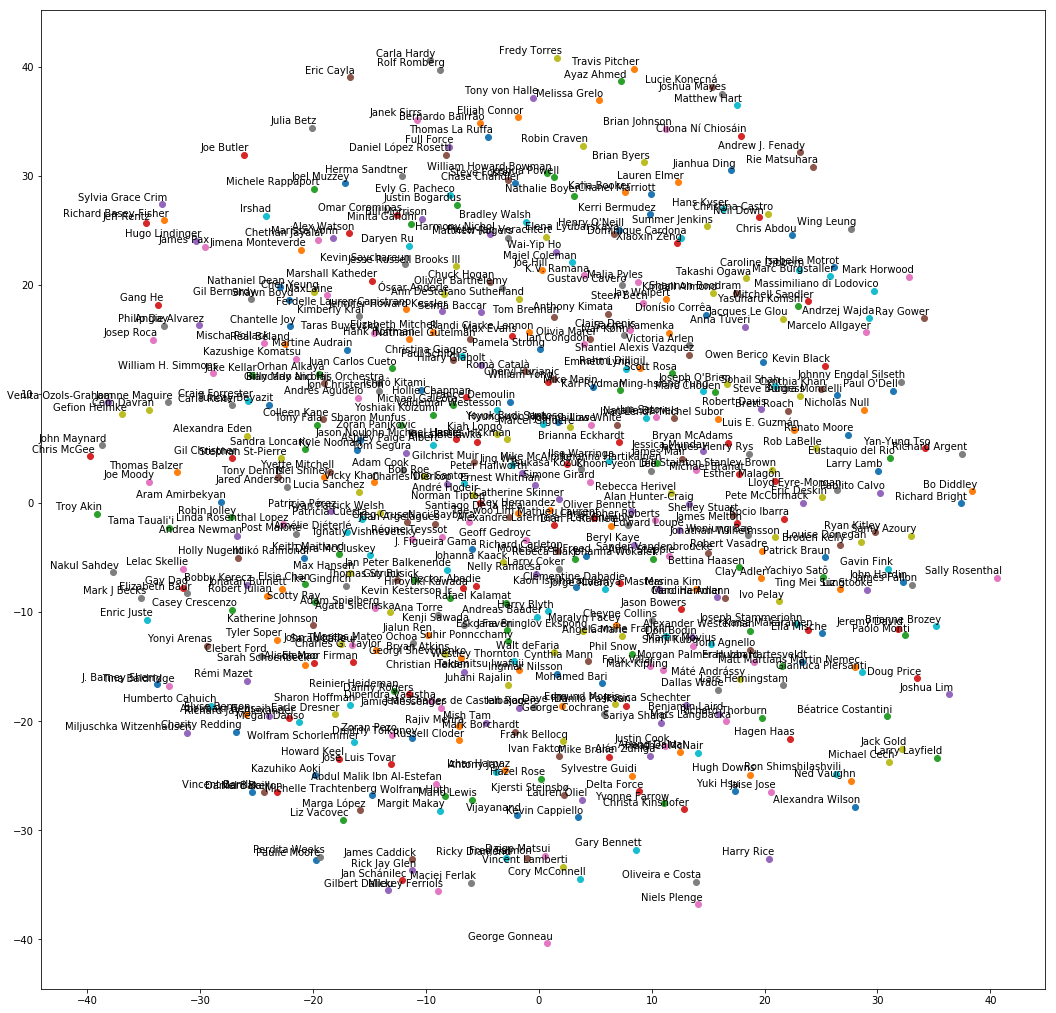

In [13]:

from sklearn.manifold import TSNE
    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_name_dict[scalar_to_id_dict[i]][0] for i in range(plot_only)]
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x,y)
    plt.annotate(label,
                    xy=(x, y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.savefig("/home/steich/NF_Prize_Data/data/tsne_actor_embeddings2.png")
plt.show()
    

In [14]:
#First, get the data out of the .tsv files

#using the name.basics.tsv file we can create a 
#cast/crew id -> name dictionary
movie_id_to_name_dict = {}
with open('/home/steich/NF_Prize_Data/data/imdb/title.basics.tsv') as iFile:
    for line in iFile:
        fields = line.split('\t')
        movie_id_to_name_dict[fields[0]] = fields[2]

In [15]:
movie_embeddings = []
movie_names = []
for movie in movie_dict:
    if movie in movie_id_to_name_dict.keys():
        principles = [id_to_name_dict[i][1] for i in movie_dict[movie]]
        p_vects = [final_embeddings[i - 1] for i in principles]
        movie_embeddings.append(np.mean(p_vects, axis=0))
        movie_names.append(movie_id_to_name_dict[movie])

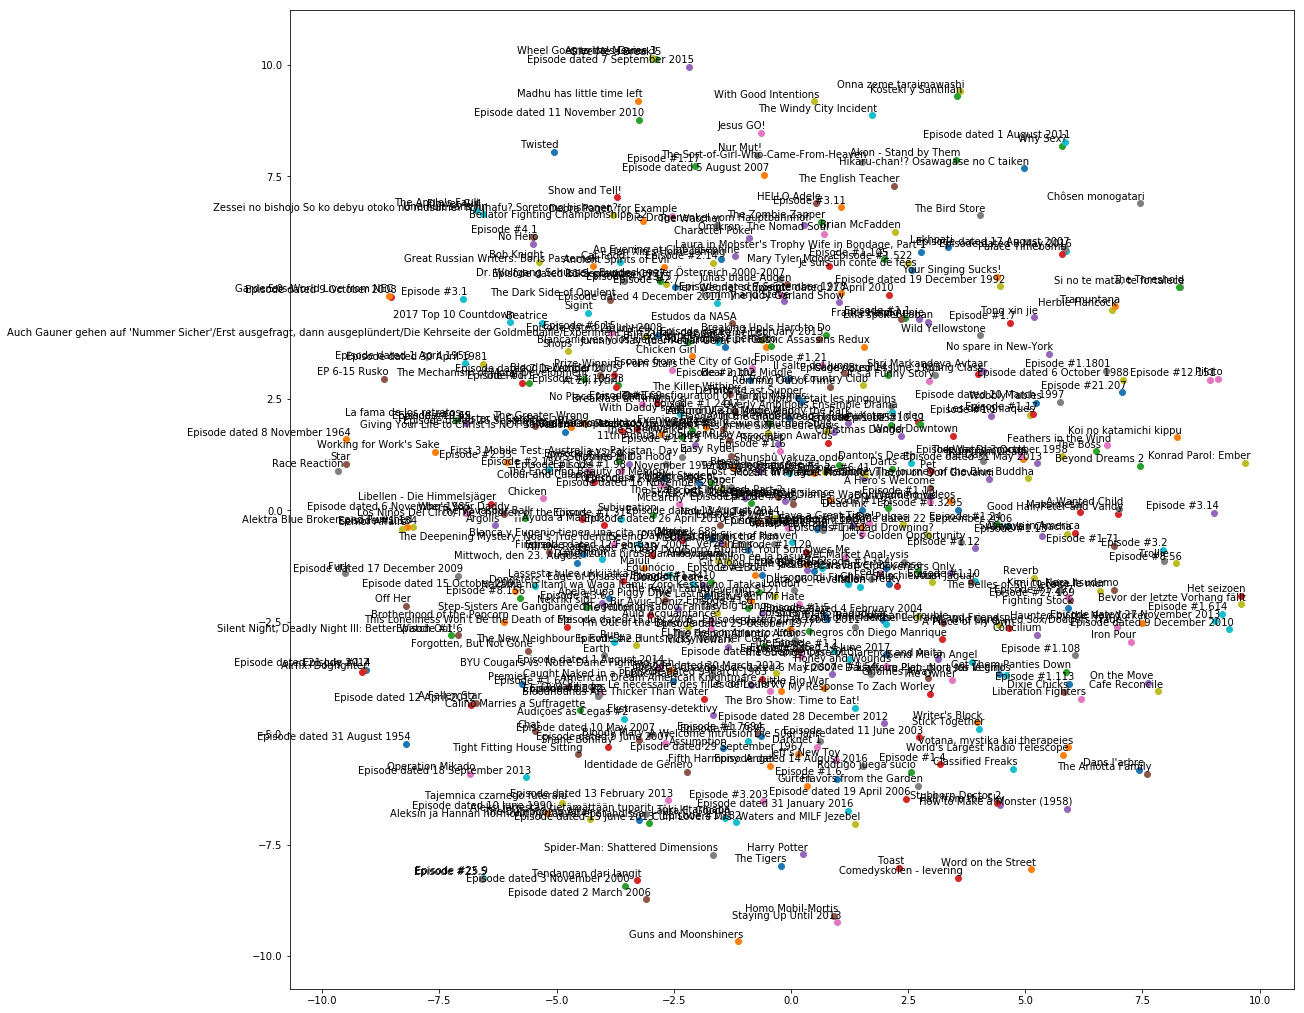

In [19]:
m_tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
n = len(movie_embeddings)
sample = random.sample(range(n), 500)
low_dim_embs = tsne.fit_transform([movie_embeddings[i] for i in sample])
labels = [movie_names[i] for i in sample]
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x,y)
    plt.annotate(label,
                    xy=(x, y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.savefig("/home/steich/NF_Prize_Data/data/tsne_movie_embeddings3.png")
plt.show()

In [18]:
with open('/home/steich/NF_Prize_Data/data/movie_embeddings2.txt', 'w') as f:
    for i, embs in enumerate(movie_embeddings):
        name = movie_names[i]
        emb_str = [str(emb) for emb in embs]
        f.write(name + '\t' + '\t'.join(emb_str) + '\n')